In [1]:
import pandas as pd

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Embedding, Flatten, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


<h1>Traitement des données</h1>

In [15]:
# chargement des deux tables
data = pd.read_csv("./dataset2/train.csv")

In [16]:
data.sample(5)

,id,title,author,text,label
7593,7593,The Orthodox Nationalist: Albania’s Alliance W...,Sven Longshanks,"Radio Aryan October 28, 2016 \nDr Matthew Raph...",1
18774,18774,Who rode it best? Jesse Jackson mounts up to f...,Brett T.,Who rode it best? Jesse Jackson mounts up to f...,1
4103,4103,Game Over: These Guys Are No Longer Big Sports...,Sridhar Pappu,You would be to find someone more devoted to...,0
3807,3807,Millions Of Drunk Cubs Fans Rioting In Heaven ...,NaN,Most Hotly Contested Down-Ballot Measures Of 2...,1
2310,2310,A New Email Investigation on Clinton Could Has...,Daniel Haiphong,20 Shares\n1 18 0 1\nThe two-party corporate d...,1


In [17]:
print(f"Nombre de références : {data.title.count()}")

Nombre de références : 20242


In [18]:
# ici on ne s'intéresse qu'au titre et au label
del data["id"]
del data["author"]
del data["text"]

In [19]:
data.sample(10)

,title,label
16780,Trump’s Blistering Speech at CPAC Follows Bann...,0
10361,#2820: Clinton 8(a) Pig Farm Servers – Boeing ...,1
9983,BREAKING: Miami Woman BUSTED On Election Fraud...,1
12781,"Gorsuch, Like Previous Supreme Court Nominees,...",0
10479,Millions Gather Under Times Square Countdown C...,1
9355,German Court Convicts Syrian Migrant of Plotti...,0
1802,It is Legal For Law Enforcement to Use Armed D...,1
2971,"Israel to build new settler homes in Shiloh, d...",1
16105,News: Possible Voter Suppression? Lots Of Lase...,1
8833,Mike Pences Plane Slides off Runway at LaGuardia,1


In [20]:
# nettoyage des données (ponctuations)

stopWords = set(stopwords.words("english"))

def cleanText(text):
    forbidden = {",","@",";","/","-",":",".","!","?", "#","\"","(",")","\'","’","‘","–"}
    res = str(text)
    if res != None:
        for elm in forbidden:
            res = res.replace(elm, "")
        res = res.split()
        cleaned = []
        for word in res:
            if not word in stopWords:
                cleaned.append(word)
        res = " ".join(cleaned)
    return res

data["title"] = data["title"].apply(cleanText)

data.sample(10)

,title,label
9436,Irving Fields Composer Who Infused Songs With ...,0
1266,YIELD… Funeral Ahead…,1
1813,Like It Or Not This Election Is A Referendum,1
6163,US Wrestlers Find They Have Passionate Fans Ir...,0
17991,Limbaugh Democratic Party Has Become Largest H...,0
15784,PUTIN WANTS RADICALLY LIBERAL JEWISH BILLIONAI...,1
3874,Trump Threatens Europes Stability Top Leader W...,0
9454,Il saoule tout le monde avec son analyse polit...,1
11023,A Rare Venture Capitalist — Female RetailFocus...,0
4678,Comment When Good People Share Bad Things — He...,1


In [21]:
# on sépare les données en données d'entraînement et données de test (80% et 20%)
x_train, x_test, y_train, y_test = train_test_split(data["title"], data["label"], test_size=0.25, random_state = 42)
print(f"Données d'entrainement : {len(x_train)}")
print(f"Données de test : {len(x_test)}")

Données d'entrainement : 15600
Données de test : 5200


In [22]:
x_train

3788     Donald Trumps Secret Weapon Letters Love Flatt...
11724    Can Cities Sue Banks Over Predatory Loans Supr...
9409     John Carney Economic Indicators Demonstrate Co...
1276     So ein Ärger Obama hat über Nacht sämtliche At...
14322    Biden Implies Trump Legitimized Hate Speech Ra...
                               ...                        
11284    TRUMP SUPPORTER GOT NUTS On MSNBC Reporter Cov...
11964    Watch Megyn Kelly almost cry air Trump took le...
5390     How Pay College With Less Stress The New York ...
860               Russian scientists track sea lions space
15795    Heseltine strangled dog part Thatcher cabinet ...
Name: title, Length: 15600, dtype: object

In [23]:
max_features = 10000 # taille max du vocab
maxlen = 30 # taille max de séquence

In [24]:
# vectorisation naïve en "one-hot"
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

In [25]:
# vectorisation des données d'entraînement
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=maxlen)

In [26]:
# vectorisation des données de test
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [27]:
batch_size = 256
nb_epochs = 20
embedded_dim = 100

In [28]:
model = Sequential()
model.add(Embedding(max_features, output_dim=embedded_dim, input_length=maxlen, trainable=True))
model.add(Reshape((1, 30, 100)))
model.add(Conv2D(64, (3, 1), padding="same"))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 1), padding="same"))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0002), metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 30, 100)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 30, 64)         19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 30, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 30, 32)         6176      
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [29]:
progress = model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epochs, validation_data=(x_test, y_test))

C:\Users\Shadow\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15600 samples, validate on 5200 samples
Epoch 1/20
15600/15600 [==============================] - 2s 130us/step - loss: 0.6707 - accuracy: 0.7410 - val_loss: 0.6327 - val_accuracy: 0.7802
Epoch 2/20
15600/15600 [==============================] - 0s 31us/step - loss: 0.5458 - accuracy: 0.7753 - val_loss: 0.4443 - val_accuracy: 0.8115
Epoch 3/20
15600/15600 [==============================] - 0s 31us/step - loss: 0.3464 - accuracy: 0.8632 - val_loss: 0.2800 - val_accuracy: 0.8887
Epoch 4/20
15600/15600 [==============================] - 0s 31us/step - loss: 0.2058 - accuracy: 0.9310 - val_loss: 0.2045 - val_accuracy: 0.9183
Epoch 5/20
15600/15600 [==============================] - 0s 32us/step - loss: 0.1358 - accuracy: 0.9531 - val_loss: 0.1767 - val_accuracy: 0.9263
Epoch 6/20
15600/15600 [==============================] - 0s 31us/step - loss: 0.0980 - accuracy: 0.9683 - val_loss: 0.1695 - val_accuracy: 0.9338
Epoch 7/20
15600/15600 [==============================] - 0s 32us/st

In [30]:
model.save("confirmation.h5")

In [31]:
# art plastique du turfu featuring le poto matplotlib
from matplotlib import pyplot as plt

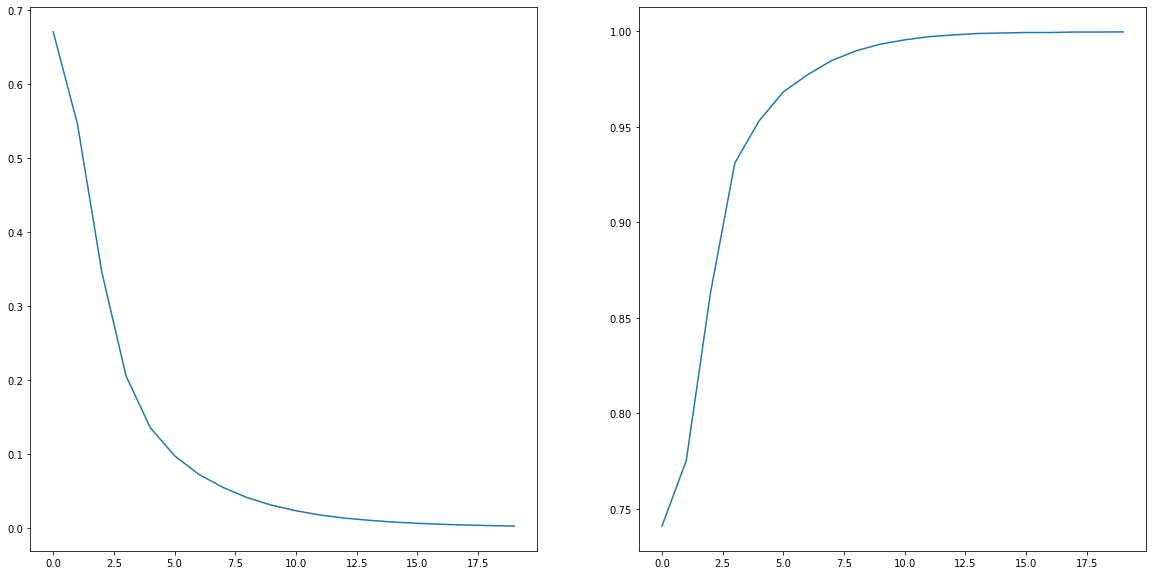

In [32]:
figure, ax = plt.subplots(1, 2)
figure.set_size_inches(20,10)

ax[0].plot(progress.history["loss"])

ax[1].plot(progress.history["accuracy"])

plt.show()

In [34]:
to_predict = data.sample(5)

In [35]:
X_test = to_predict["title"]
X_test

8588     Comment FBI Makes Stunning Reversal Reopens Cl...
18510    Trump And Clinton Have Both Assembled An Army ...
5611     Jury Delivers Guilty Verdict Murder Police Off...
12935    Tory Peer Warsi UK Should Forget About About I...
14256                                        Master Estate
Name: title, dtype: object

In [36]:
Y_test = to_predict["label"]
Y_test

8588     1
18510    1
5611     0
12935    0
14256    1
Name: label, dtype: int64

In [37]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,   52,   44,  286, 2194, 3668,
       1646,   10,  128,   20, 4102,    2,  939, 4349])

In [38]:
model.predict(X_test)

array([[9.9999964e-01],
       [1.0000000e+00],
       [4.4526312e-09],
       [1.2228286e-02],
       [9.9956292e-01]], dtype=float32)

In [39]:
X_test

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   52,   44,  286, 2194, 3668,
        1646,   10,  128,   20, 4102,    2,  939, 4349],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    5,   42,   10,   53,  903, 7164,  183,  537,   18, 3050,
           9, 4616, 2496,   42, 3930,    1,   19,  776],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  980, 2288,  594,
        3842,  664,   57,  796,    1,    2,    3,    4],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, 3843,  376,
         121, 1942,   41,   41, 6441, 8782, 3719, 1805],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 

In [65]:
test_data = pd.read_csv("./dataset2/test.csv")
test_data.sample(10)

,id,title,author,text
4422,25222,BREAKING: CLINTON CLEARED...Was This A Coordin...,Fed Up,\nLimbaugh said that the revelations in the Wi...
4536,25336,Johnson & Johnson Ordered To Pay $72 Million I...,Collective Evolution,\nThis is one out of several cases raising c...
3915,24715,France Closes 4 Mosques for Promoting ‘Radical...,Henry Wolff,France Closes 4 Mosques for Promoting ‘Radical...
2758,23558,Silver Signals The Flight To Real Safety Is On...,The Doc,Tweet Home » Silver » Silver News » Silver Sig...
4124,24924,Hafiz Saeed and Geelani to dress up as mime ar...,Citizen Satirist,Hafiz Saeed and Geelani to dress up as mime ar...
2367,23167,Allen West Reveals How Obama’s Pentagon Just D...,V Saxena,UNREAL: Calif. Soldiers Billed for Thousands A...
4430,25230,Van Jones at University of Chicago: Safe Space...,Tom Ciccotta,Speaking at the University of Chicago Institut...
789,21589,Light Sentence for Brock Turner in Stanford Ra...,Liam Stack,A recall effort against a California judge was...
449,21249,Devin Nunes: Trump and Transition Team Members...,Michelle Moons,House Intelligence Committee Chair Rep. Devin ...
5063,25863,Customizing Truth,NaN,License DMCA Part I -- Liars For those who mig...


In [66]:
del test_data["author"]
del test_data["text"]
test_data.sample(10)

,id,title
889,21689,Iraqis in Mosul Find US Missiles at Captured I...
4574,25374,Coulter on Kathy Griffin: Victims Are the Bigg...
3330,24130,Fact Check: Democrats Have Created Twice As Ma...
2019,22819,Trump's Wall Might Only Be a Fence in Some Are...
745,21545,McClatchy: Breitbart’s Aaron Klein Leads Influ...
4496,25296,Anthony Weiner SEX Hoax? Hillary Stunt To Rig ...
558,21358,The Humiliating Practice of Sex-Testing Female...
3445,24245,Paul McCartney Sues to Get Back His Beatles So...
3007,23807,Watch: More Car Mayhem in ’Fate of the Furious...
1095,21895,Federation of Greek Women: statement on the vi...


In [67]:
test_data["title"] = test_data["title"].apply(cleanText)
test_data.sample(10)

,id,title
4987,25787,Flashback Clinton cheered 11thhour indictment ...
3078,23878,FBI debunks Hillarys Conspiracy Theory Trump N...
3642,24442,The Legacy David Letterman Icon Grizzled Gener...
4125,24925,Powerful Docudrama The Hidden Rebellion Expose...
1224,22024,Greys Anatomy Star Jesse Williams Trump Pig
112,20912,POLLAK Adm Mike Mullens Partisan Attack Steve ...
3726,24526,What Rembrandt Did Teenager 4 His Sense Works ...
2368,23168,Bricklayers rejoice
403,21203,Feds Establish Support Program Victims Crimina...
2435,23235,Its Not Broken So Lets Break It“California Set...


In [68]:
import numpy as np

x_confirm = tokenizer.texts_to_sequences(test_data["title"])
x_confirm = pad_sequences(x_confirm, maxlen=maxlen)
labels = np.round(model.predict(x_confirm)).astype("int")

In [69]:
del test_data["title"]

In [70]:
test_data["label"] = labels
test_data.sample(10)

,id,label
219,21019,1
2660,23460,1
4984,25784,0
1642,22442,1
2699,23499,0
4548,25348,0
3784,24584,1
305,21105,1
4366,25166,0
1647,22447,1


In [71]:
test_data.to_csv("submission.csv", index=False)